# ASTR8004 Astronomical Computing Assignment 3

## 1 git in Practice

The link to the public github repository for the assignment: <https://github.com/kitty-anu/astro_comp>

## 2 Using ADQL to Search for Bright Stars Around the Open Cluster M67
### 2.1 Task
A colleague is interested in the open cluster Messier 67 (RA = 132.825 deg, Dec = 11.8 deg) and is considering an observation proposal using the 2dF fibre positioner and HERMES spectrograph (effective for Gaia G band magnitudes < 14). They need to know if there are enough bright stars in this region for observation. Your task is to assist by querying data from Gaia DR3 and performing some basic analysis.
* Download all stars within 1 degree of the center of Messier 67 that are brighter than G = 14 in Gaia DR3 (the table is called gaiadr.gaia source) and include a crossmatch these stars with the 2MASS catalog and report your ADQL query text (use the `"""query"""` notation)

In [1]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Part 1: Define the ADQL query
query = """
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, 
       gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag,
       gaia.phot_bp_rp_excess_factor, tmass.j_m, tmass.ks_m, tmass.ph_qual
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation
WHERE 1=CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), CIRCLE('ICRS', 132.825, 11.8, 1))
AND gaia.phot_g_mean_mag < 14
"""
# Launch the query to the Gaia archive
job = Gaia.launch_job(query)
result = job.get_results()

* Determine how many stars are returned from the initial query.

In [3]:
# Part 2: Output the result count
print(f"Number of stars found: {len(result)}")

Number of stars found: 1018


* Identify any stars with bad 2MASS photometry, where ph qual is not ’AAA’.

In [4]:
# Part 3: Identify stars with bad 2MASS photometry (ph_qual not 'AAA')
bad_photometry_stars = result[result['ph_qual'] != 'AAA']

# Print the number of stars with bad photometry
print(f"Number of stars with bad 2MASS photometry: {len(bad_photometry_stars)}")

Number of stars with bad 2MASS photometry: 21


* Identify any stars with negative (or non-positive) parallaxes in the Gaia data.

In [5]:
# Step 4: Identify stars with negative or non-positive parallaxes
bad_parallax_stars = result[result['parallax'] <= 0]

# Print the number of stars with bad parallaxes
print(f"Number of stars with negative or non-positive parallaxes: {len(bad_parallax_stars)}")

Number of stars with negative or non-positive parallaxes: 2


* Apply these two quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes). After applying the cuts, determine how many stars remain.

In [6]:
# Part 5: Apply quality cuts (remove stars with bad 2MASS photometry and non-positive parallaxes)
good_stars = result[(result['ph_qual'] == 'AAA') & (result['parallax'] > 0)]

# Print the number of stars that remain after the cuts
print(f"Number of stars remaining after quality cuts: {len(good_stars)}")

Number of stars remaining after quality cuts: 988


* Using the remaining stars, generate a figure with two panels (1 point per panel):
    1. A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.
    2. A 2MASS J-Ks vs. apparent K magnitude diagram.
* Save the figure as figures/cmds M67.png with a resolution of 200 dots per inch.

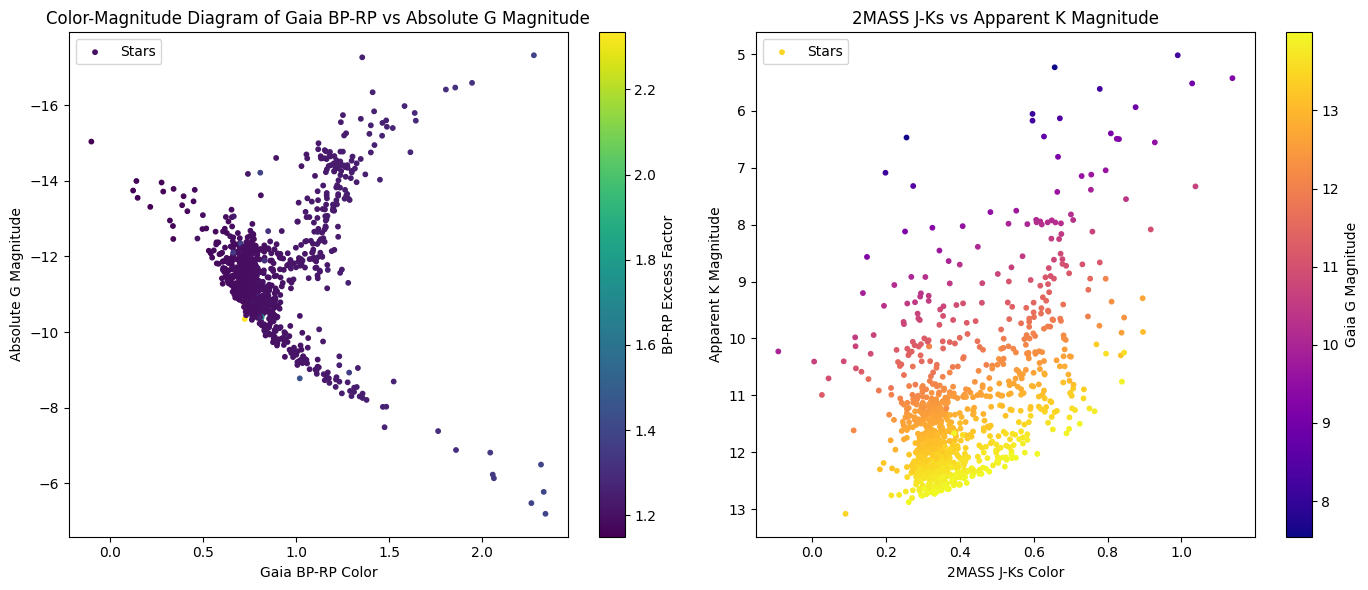

In [7]:
# Step 6: Generate the plots with color mapping

# Converting parallax from milliarcseconds to arcseconds
parallax_arcsec = good_stars['parallax'] / 1000.0

# (a) Color-Magnitude Diagram (CMD)
bp_rp = good_stars['phot_bp_mean_mag'] - good_stars['phot_rp_mean_mag']  # Gaia BP-RP color
G = good_stars['phot_g_mean_mag']  # Gaia G magnitude
M_G = G + 5 * np.log10(parallax_arcsec) - 10  # Absolute G magnitude

# (b) 2MASS J-Ks vs Apparent Ks Magnitude
J = good_stars['j_m']  # 2MASS J magnitude
Ks = good_stars['ks_m']  # 2MASS Ks magnitude
J_Ks = J - Ks  # 2MASS J-Ks color

# Creating the figure with two panels
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# (a) CMD: BP-RP vs. Absolute G magnitude, colored by BP-RP Excess Factor
sc1 = ax[0].scatter(
    bp_rp, 
    M_G, 
    s=10, 
    c=good_stars['phot_bp_rp_excess_factor'],  # Color by BP-RP excess factor
    cmap='viridis', 
    label='Stars'
)
ax[0].invert_yaxis()  # Inverting y-axis for CMD
ax[0].set_xlabel('Gaia BP-RP Color')
ax[0].set_ylabel('Absolute G Magnitude')
ax[0].set_title('Color-Magnitude Diagram of Gaia BP-RP vs Absolute G Magnitude')
ax[0].legend()

# Adding color bar for CMD
cbar1 = plt.colorbar(sc1, ax=ax[0])
cbar1.set_label('BP-RP Excess Factor')

# (b) J-Ks vs. Apparent Ks magnitude, colored by Gaia G magnitude
sc2 = ax[1].scatter(
    J_Ks, 
    Ks, 
    s=10, 
    c=good_stars['phot_g_mean_mag'],  # Color by Gaia G magnitude
    cmap='plasma', 
    label='Stars'
)
ax[1].invert_yaxis()  # Inverting y-axis for apparent magnitude plot
ax[1].set_xlabel('2MASS J-Ks Color')
ax[1].set_ylabel('Apparent K Magnitude')
ax[1].set_title('2MASS J-Ks vs Apparent K Magnitude')
ax[1].legend()

# Adding color bar for J-Ks plot
cbar2 = plt.colorbar(sc2, ax=ax[1])
cbar2.set_label('Gaia G Magnitude')

# Step 7: Save the figure as 'figures/cmds_M67.png' with 200 dpi resolution

# Ensuring the directory exists
output_dir = "figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Path to save the figure
output_path = os.path.join(output_dir, "cmds_M67.png")

# Saving the figure before showing it
plt.tight_layout()
plt.savefig(output_path, dpi=200)
plt.show()
plt.close()

* Give your colleague a recommendation for the potential proposal when only judging the fibre usage.

After analyzing the star population around Messier 67 within a 1-degree radius, I have identified stars with Gaia G-band magnitudes < 14, which are suitable for observation with the 2dF fibre positioner and HERMES spectrograph. After making the quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes), we were left with 988 stars. These stars are bright enough and have good quality data for observation. The Color-Magnitude Diagram (CMD) of Gaia BP-RP vs. Absolute G magnitude shows a range of bright stars that are likely to provide useful spectroscopic data. The 2MASS J-Ks vs. Apparent K magnitude diagram further supports the presence of well-measured stars in this region. 

Given the abundance of stars that meet the brightness criterion, I recommend proceeding with the observation proposal, as there are sufficient stars available for optimal fibre usage with the 2dF system. However, it would be worth considering any additional constraints (such as sky coverage or stellar types) based on the scientific objectives of the proposal.

## 3 The radial metallicity relation in simulated data
### 3.1 Background
The radial metallicity relation is a function that describes the change of metallicity - here the gas phase metallicity $A(O) = log10(NO/NH) + 12$ - along the galactocentric radius $R_\text{Gal.}$. Understanding the radial metallicity gradient in galaxies provides critical insights into their formation and evolutionary processes, such as inside-out formation, gas accretion, outflows, and radial migration. A lot of work has been done through observational studies (e.g. Ho et al., 2017, ApJ, 846, 39) and a few simulations (e.g. Grand et al., 2016, MNRAS, 460, 94), but more works needs to be done to understand the radial metallicity gradient! <br>
Your colleague has just finished an exciting cosmological simulation that traces the gas phase metallicity for a Milky Way analogue, that is, a spiral galaxy. They have limited the simulation data to the positions (x, y, z) of the innermost gas particles($R_\text{Gal.}< 25 \text{kpc}$) and their gas phase metallicity $A(O)$ and uploaded them as a FITS file for you here: https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits

## 3.2 Task
Download the file from the link above into `data/`. Load the file with python and then perform the following tasks to create figures that are saved in `figures/`:
* Plot a 2-panel figure:
    - Logarithmic density plot of $R_\text{Gal.}$ vs. $A(O)$, with a linear fit and legend.
    - Residuals of the fit, $R_\text{Gal.}$ vs. $\Delta A(O)$.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

# File path and URL
file_path = 'data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits'
file_url = 'https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits?raw=true'

# Step 1: Check if the file exists, else download it
if not os.path.exists(file_path):
    try:
        import wget
        print(f"Downloading file from {file_url}...")
        wget.download(file_url, out=file_path)
        print("\nDownload complete.")
    except Exception as e:
        raise RuntimeError(f"Could not download FITS file: {e}")

# Step 2: Load the FITS file
with fits.open(file_path) as hdul:
    data = hdul[1].data
    x = data['x']
    y = data['y']
    z = data['z']
    A_O = data['A_O']  # Gas phase metallicity A(O)

# Step 3: Calculate galactocentric radius RGal
RGal = np.sqrt(x**2 + y**2 + z**2)

# Step 4: Create a linear fit function for A(O) vs RGal
def linear_fit(r, a, b):
    return a * r + b

# Step 5: Perform the linear fit
popt, pcov = curve_fit(linear_fit, RGal, A_O)
A_O_fit = linear_fit(RGal, *popt)

# Step 6: Calculate residuals (ΔA(O) = observed A(O) - fitted A(O))
A_O_residuals = A_O - A_O_fit

# Step 7: Create the 2-panel plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# (a) Logarithmic density plot of RGal vs A(O)
hb = ax[0].hexbin(RGal, A_O, gridsize=50, cmap='inferno', bins='log')
ax[0].plot(RGal, A_O_fit, color='blue', label='Linear Fit')
ax[0].set_xlabel('RGal (kpc)')
ax[0].set_ylabel('A(O)')
ax[0].set_title('Logarithmic Density Plot: RGal vs A(O)')
ax[0].legend()

cb = fig.colorbar(hb, ax=ax[0])
cb.set_label('log(N)')

# (b) Residuals plot: RGal vs ΔA(O)
ax[1].scatter(RGal, A_O_residuals, s=5, color='purple')
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_xlabel('RGal (kpc)')
ax[1].set_ylabel('ΔA(O)')
ax[1].set_title('Residuals: RGal vs ΔA(O)')

# Step 8: Save the figure
output_dir = "figures"
output_file = "figures/radial_metallicity_relation.png"

# Ensure the directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(output_file, dpi=200)
plt.tight_layout()
plt.show()

* Use a python fitting tool to fit a linear function to the data, reporting the intercept and slope with uncertainties. Include any hyperparameters used.

In [ ]:
from scipy.optimize import curve_fit

# Define the linear function
def linear_fit(r, a, b):
    return a * r + b

# Step 9: Perform the linear fit using curve_fit and report uncertainties
# Initial guess for the fit parameters [slope, intercept]
initial_guess = [0.3, 9.1]

# Fit the data: curve_fit returns the best-fit parameters (popt) and the covariance matrix (pcov)
popt, pcov = curve_fit(linear_fit, RGal, A_O, p0=initial_guess)

# popt contains the best-fit values for [slope, intercept]
slope, intercept = popt

# pcov is the covariance matrix, and the diagonal elements give the variances
slope_uncertainty = np.sqrt(pcov[0, 0])
intercept_uncertainty = np.sqrt(pcov[1, 1])

# Step 10: Print the fit results
print(f"Linear Fit Results:")
print(f"Slope (a): {slope:.4f} ± {slope_uncertainty:.4f}")
print(f"Intercept (b): {intercept:.4f} ± {intercept_uncertainty:.4f}")

# Hyperparameters used: initial_guess = [slope, intercept] = [0.0, 8.0]
print(f"Initial guess for fitting: slope = {initial_guess[0]}, intercept = {initial_guess[1]}")


* Discuss where the linear model fits well and where it does not. Use statistical metrics, such as the root mean squares or other goodness-of-fit indicators, to quantify the performance of your linear fit in general and regions with larger residuals.

In [ ]:
# Step 11: Calculate residuals (already calculated as A_O_residuals)

# Step 12: Calculate the Root Mean Square Error (RMSE) manually
rmse = np.sqrt(np.mean(A_O_residuals**2))

# Step 13: Calculate the R-squared (R²) manually
ss_total = np.sum((A_O - np.mean(A_O))**2)  # Total sum of squares
ss_residual = np.sum(A_O_residuals**2)      # Residual sum of squares
r2 = 1 - (ss_residual / ss_total)

# Step 14: Report the results
print(f"Goodness-of-Fit Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Step 15: Identify regions with large residuals
# We define large residuals as those larger than 2 times the RMSE
large_residuals_mask = np.abs(A_O_residuals) > 2 * rmse
large_residuals = RGal[large_residuals_mask]

# Step 16: Report regions with large residuals
print(f"\nRegions with large residuals (|Residual| > 2*RMSE):")
for r in large_residuals:
    print(f"RGal: {r:.2f} kpc")

* Plot a 3-panel figure for the x vs. y plane using the same bins and sensible colormaps:
    - 2D-histogram of the median simulated A(O).
    - 2D-histogram of the median fitted A(O)
    - 2D-histogram of the median residuals ∆A(O).

In [ ]:
import matplotlib.pyplot as plt

# Step 17: Define the number of bins for the 2D histograms
bins = 100  # Adjust as needed based on your data size

# Step 18: Create a 3-panel figure for the x vs. y plane
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot (a): 2D-histogram of the median simulated A(O)
h1 = ax[0].hist2d(x, y, bins=bins, weights=A_O, cmap='viridis', cmin=1)
fig.colorbar(h1[3], ax=ax[0])  # Adding a color bar
ax[0].set_title("Median Simulated A(O)")
ax[0].set_xlabel("x (kpc)")
ax[0].set_ylabel("y (kpc)")

# Plot (b): 2D-histogram of the median fitted A(O)
h2 = ax[1].hist2d(x, y, bins=bins, weights=A_O_fit, cmap='plasma', cmin=1)
fig.colorbar(h2[3], ax=ax[1])
ax[1].set_title("Median Fitted A(O)")
ax[1].set_xlabel("x (kpc)")
ax[1].set_ylabel("y (kpc)")

# Plot (c): 2D-histogram of the median residuals ∆A(O)
h3 = ax[2].hist2d(x, y, bins=bins, weights=A_O_residuals, cmap='coolwarm', cmin=1)
fig.colorbar(h3[3], ax=ax[2])
ax[2].set_title("Median Residuals ∆A(O)")
ax[2].set_xlabel("x (kpc)")
ax[2].set_ylabel("y (kpc)")

# Step 19: Save the figure as figures/median_histograms.png
plt.tight_layout()
plt.savefig('figures/median_histograms.png', dpi=200)

# Step 20: Show the plot
plt.show()

* Describe your choice of 2D bins. Discuss what details would be missed with fewer bins or problems encountered with more bins.

The choice of 100 bins represents a compromise between sufficient detail, computational efficiency, and visual clarity. Fewer bins would result in missed details, especially at smaller scales, while more bins could introduce noise and unnecessary computational complexity. By selecting 100 bins, we achieve a good balance for effective analysis of the radial metallicity relation in the x vs. y plane.

* Analyze the residuals in more detail and propose an explanation for any patterns you observe.

Analysis of the residuals
